## Getting Started with Spins

Modeling spins often requires more involved 3D manipulations and visualizations, and this notebook gives an introduction to these capabilities in REBOUND/REBOUNDx.

In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We consider a case of a hot Jupiter around an A-type star ($R_\odot \approx 5\times10^{-3} AU$, $R_J \approx 5\times10^{-4} AU$)

In [2]:
sim = rebound.Simulation()
sim.units = ('AU', 'Msun', 'yr')
sim.add(m=2, r=1e-2)
sim.add(m=3.e-3, r=5e-4, a=0.03)
ps = sim.particles

sim.integrator = "whfast"
sim.dt = ps[1].P/12 # timestep is a fraction of the orbital period
sim.move_to_com()

To model the spins (and add forces that cause them to evolve), we add `tides_spin` forces:

In [3]:
rebx = reboundx.Extras(sim)
sf = rebx.load_force("tides_spin")
rebx.add_force(sf)

To model the spins, we need to set the bodies' moments of inertia $I$, and angular spin frequency vectors $\Omega$. To speed things up a bit, we assume rapid spin periods of 3 and half a day for the star and planet, respectively. 

We can set the spin vectors directly in Cartesian components, but often it's easier to think of these in terms of a magnitude for the angular spin frequency and two spherical angles: $\theta$ (polar angle from the $z$ axis) and $\phi$ (azimuthal angle from the $x$ axis). Since above we didn't set an inclination for the hot Jupiter orbit, it defaulted to 0, so the $z$ axis is the orbit normal. $\theta$ is therefore just the obliquity for each body. We could calculate the Cartesian components ourselves, or use REBOUND convenience functions as below:

In [4]:
# Star parameters
ps[0].params['Omega'] = rebound.spherical_to_xyz(magnitude=2*np.pi/(3/365), theta=np.radians(60), phi=np.radians(30))
ps[0].params['I'] = 0.1 * ps[0].m * ps[0].r**2

# Planet parameters
ps[1].params['Omega'] = rebound.spherical_to_xyz(magnitude=2*np.pi/(0.5/365), theta=np.radians(30), phi=0)
ps[1].params['I'] = 0.25 * ps[1].m * ps[1].r**2

The next step is mandatory: to track the evolution of the spin axis, you MUST initialize the spin ODEs. Otherwise the spin axis will remain stationary and you won't see anything interesting!

In [5]:
rebx.initialize_spin_ode(sf)

Finally, in order for bodies to feel tides and deform from perfect spheres so that the spins will evolve, we additionally need to set their `k2` Love numbers. 

In [6]:
ps[0].params['k2'] = 0.1
ps[1].params['k2'] = 0.3

Now, we integrate. We'll track the planet and star spin vectors, $\Omega_{\rm planet}$ and $\Omega_{\rm star}$, as well as the orbit normal (planet's specific angular momentum vector), and our energy error:

In [7]:
%%time
tmax = 4e4*ps[1].P
Nout = 1000
times = np.linspace(0, tmax, Nout)

Omega_planet = np.zeros((Nout, 3))
Omega_star = np.zeros((Nout, 3))
orbit_normal = np.zeros((Nout, 3))
Es = np.zeros(Nout)
E0 = sim.energy() + rebx.tides_spin_energy()
for i, t in enumerate(times):
    Omega_planet[i] = ps[1].params['Omega']
    Omega_star[i] = ps[0].params['Omega']
    orbit_normal[i] = ps[1].hvec
    sim.integrate(t)
    E = sim.energy() + rebx.tides_spin_energy()
    Es[i] = np.abs((E-E0)/E0)

CPU times: user 507 ms, sys: 1.57 ms, total: 509 ms
Wall time: 508 ms


If we plot the planet's spin vector (sx, sy) over time, we see it's rather difficult to interpret:

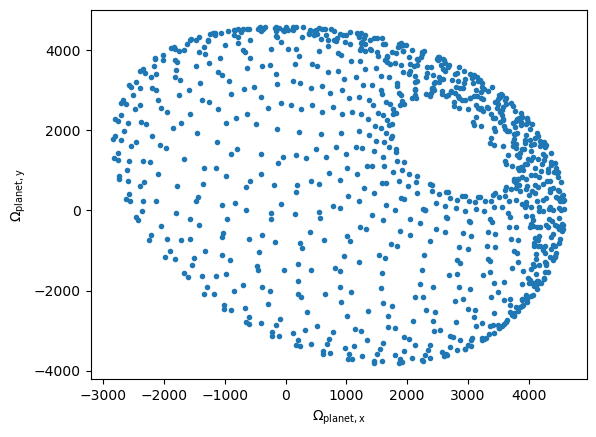

In [8]:
fig, ax = plt.subplots()
ax.plot(Omega_planet[:,0], Omega_planet[:,1], '.')
ax.set_xlabel('$\\Omega_{\\rm planet, x}$')
ax.set_ylabel('$\\Omega_{\\rm planet, y}$');

We can check that the problem isn't to do with our integration by checking our energy error, which looks good

Text(0, 0.5, 'Fractional Energy Error')

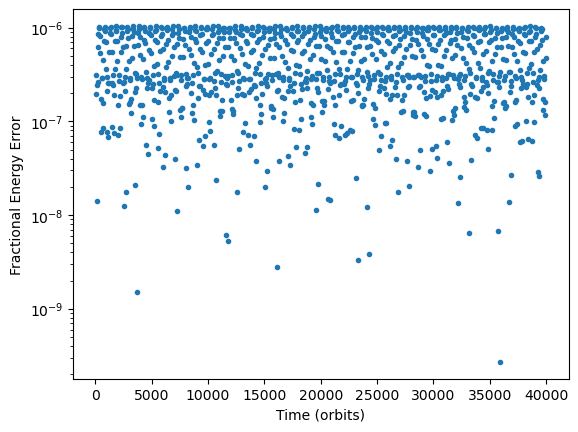

In [9]:
fig, ax = plt.subplots()
ax.plot(times/ps[1].P, Es, '.')
ax.set_yscale('log')
ax.set_xlabel('Time (orbits)')
ax.set_ylabel('Fractional Energy Error')

The problem is that the planet's spin vector wants to follow (precess around) its orbit normal. We initialized the orbit normal at $t=0$ to lie along the z axis, but we can check that by the end of the simulation, the orbit normal no longer points along the z direction:

In [10]:
orbit_normal[-1]

array([ 0.11959588, -0.17871103,  1.52511643])

In many cases, the orbital angular momentum completely dominates the spin angular momenta, so if we initialize the orbital angular momentum along $z$, we can reasonably expect it to stay there from angular momentum conservation. However, we've purposefully chosen an example where this is not the case and we have to work a bit harder.

We can check the angular momentum in the orbits using the regular REBOUND function:

In [11]:
sim.angular_momentum()

[0.00034600449571675445, -0.000519478845147151, 0.0045713024561709475]

However, REBOUND does not know about any REBOUNDx parameters (including spin). We can get the total angular momentum (including both orbital and spin angular momentum) with

In [12]:
rebx.spin_angular_momentum()

[0.011121247466274485, 0.007139869472453083, 0.0076875911730132016]

We see that including the spin angular momenta substantially changes the total angular momentum, so we should expect it to significantly affect the orbital evolution. 

Let's therefore instead choose our $z$ axis as the direction of the total angular momentum (i.e. use the invariable plane as the reference plane). This way the $z$ axis always has a fixed, physically relevant meaning. 

We can do this by initializing a rotation to new coordinate axes, with the total angular momentum as our new z axis, and use it to rotate our simulation. Since we don't pass a `newx`, the new x axis defaults sensibly to the line of nodes between the invariable plane and our original reference plane (in the z cross newz direction).

In [13]:
Ltot = np.array(sim.angular_momentum()) + np.array(rebx.spin_angular_momentum())
rot = rebound.Rotation.to_new_axes(newz=Ltot)
rebx.rotate_simulation(rot)

Note that if you are used to using sim.rotate(rot), that would be incorrect. The REBOUND Simulation API does not 'know' about spins, so this would only rotate the orbits. rebx.rotate_simulation(rot) rotates both the orbits and spins. We can now check that the total angular momentum points along the z axis as expected. 

In [14]:
np.array(sim.angular_momentum()) + np.array(rebx.spin_angular_momentum())

array([1.19262239e-18, 8.67361738e-19, 1.80446090e-02])

Given that we expect the planet spin vector to want to follow its orbit normal, let's see how we might track this evolution.

In [15]:
Omega_planet = ps[1].params['Omega']
Omega_planet

[803.4613861754856, 4283.159418695908, 1430.7494317037854]

Recall that these 'sx', 'sy' and 'sz' values yield the spin vector referenced to the inertial reference frame (which we currently have lined up with the total angular momentum). If we want to calculate the planet spin vector relative to its orbital plane (with orbit normal `ps[1].hvec`), we can

In [16]:
rot = rebound.Rotation.to_new_axes(newz=ps[1].hvec)
Omega_planet_orbit = rot * Omega_planet
Omega_planet_orbit

[-1577.8749300514232, -1710.3817133673738, 3952.5882458273954]

Our `Omega_planet_orbit` is now a vector in a reference system where the $z$ axis lines up with the orbit normal (and $x$ along the orbit's ascending node in the invariable plane. See Rotations.ipynb in the REBOUND ipython_examples for more on rotations). 

The polar angle $\theta$ is thus the obliquity, which has evolved slightly from its initial 30 degrees due to the tidal interactions in our integration above.

In [17]:
mag, theta, phi = rebound.xyz_to_spherical(Omega_planet_orbit)
np.degrees(theta)

30.486903784940168

To better visualize the evolution, let's call the current state `sim.t=0`, integrate for another 40,000 orbits, and track the cartesian components of the planet and star's spin and orbit normal, now relative to the invariable plane. We will also track the cartesian components of the planet's spin relative to its orbit normal:

In [18]:
%%time
sim.t = 0
times = np.linspace(0, tmax, Nout)

Omega_star, Omega_planet, hs, Omega_planet_orbit = np.zeros((Nout, 3)), np.zeros((Nout, 3)), np.zeros((Nout, 3)), np.zeros((Nout, 3))
obls, thetas = np.zeros(Nout), np.zeros(Nout)
for i, t in enumerate(times):
    hs[i] = ps[1].hvec
    Omega_star[i] = ps[0].params['Omega']
    Omega_planet[i] = ps[1].params['Omega']
    rot = rebound.Rotation.to_new_axes(newz=ps[1].hvec)
    Omega_planet_orbit[i] = rot * Omega_planet[i]
    
    mag, thetas[i], phi = rebound.xyz_to_spherical(Omega_planet[i])
    mag, obls[i], phi = rebound.xyz_to_spherical(Omega_planet_orbit[i])
    
    sim.integrate(t)

CPU times: user 774 ms, sys: 2.51 ms, total: 777 ms
Wall time: 523 ms


It is often useful to visualize the evolution of these vectors in 3D. Here's a class that plots them in 3D (normalized to a passed `scale`):

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# Adapted from CTZhu and Ruli on https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
default_arrow_props = dict(mutation_scale=20, arrowstyle='-|>', shrinkA=0, shrinkB=0)

class Arrow3D(FancyArrowPatch):
    def __init__(self, vec, c, scale=1, *args, **kwargs):
        super().__init__((0,0), (0,0), color=c, *args, **default_arrow_props, **kwargs)
        vec = np.array(vec, dtype=float)
        vec *= scale/np.linalg.norm(vec)
        self._verts3d = [0,vec[0]], [0,vec[1]], [0,vec[2]]

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

Let's first visualize the evolution in inertial space. We see that the orbit normal (red) and the stellar spin vector (blue) both precess at constant inclination around the total angular momentum (along $z$). This makes sense since these two vectors have almost all the angular momentum (the planet's spin angular momentum is negligible), so they always have to lie on opposite sides of the z axis. 

However, it is not obvious what the planet's spin vector is doing (in black).

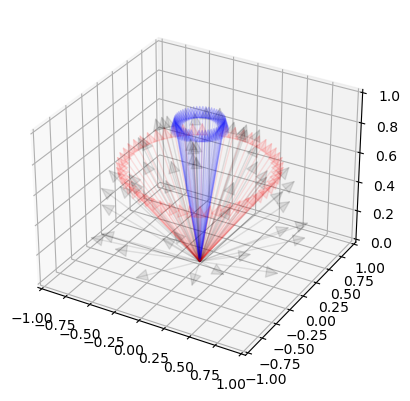

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
for i in range(0,len(Omega_star),20):
    a = Arrow3D(Omega_star[i], c='b', alpha=0.1)
    b = Arrow3D(hs[i], c='r', alpha=0.1)
    c = Arrow3D(Omega_planet[i], c='k', alpha=0.1)
    ax.add_artist(a)
    ax.add_artist(b)
    ax.add_artist(c)

If we plot the black planet spin vectors' polar angle (from the z axis over time) over time, it undergoes large variations from about 15-75 degrees. But if instead we plot the planet's obliquity, i.e., the angle between the spin vector and orbit normal, it stays approximately constant at the 30 degree obliquity we initialized the planet with.

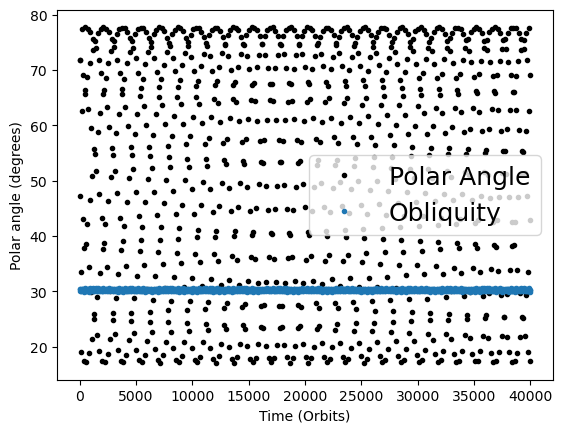

In [21]:
fig, ax = plt.subplots()
ax.plot(times/ps[1].P, np.degrees(thetas), 'k.', label='Polar Angle')
ax.plot(times/ps[1].P, np.degrees(obls), '.', label='Obliquity')
ax.set_xlabel('Time (Orbits)')
ax.set_ylabel('Polar angle (degrees)')
ax.legend(fontsize=18)

If we make a 3D plot, now in a frame rotating along with the planet's orbit normal (in red in the above 3D plot), so that the planet's orbit normal always lies along the z axis, we nicely see how the spin vector (black) precesses at constant obliquity. 

The full picture is therefore that the planet's spin precession is fast enough that it is able to adiabatically follow the slow evolution of the orbit pole. For different parameters, that might not be the case, which is the topic of Colombo's top and Cassini state equilibria!

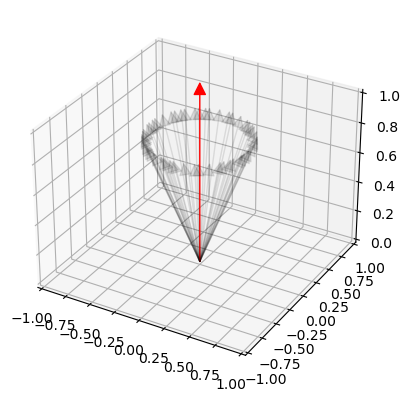

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

a = Arrow3D([0,0,1], c='r', scale=1.2)
ax.add_artist(a)
for i in range(0,len(Omega_star),20):
    a = Arrow3D(Omega_planet_orbit[i], c='k', alpha=0.1)
    ax.add_artist(a)